# Projectile Motion using PINNs


Physics Informed Neural Networks (PINNs) lie at the intersection of the traditional physics based methods and data driven Neural Networks. Using data-driven supervised neural networks to learn the model, but also using physics equations that are given to the model to encourage consistency with the known physics of the system. They have the advantage of being both data-driven to learn a model, but also able to ensure consistency with the physics, as well as being able to extrapolate accurately beyond the available data.

Let us consider the function of projectile motion (a projectile in free-fall) with the effects of gravity and drag. We know something about this problem already, in terms of the physics equations that describe projectile motion, and the relationships between them.

The equation of projectile motion in terms of the displacement(f) is as follows:

$\frac{d^{2}\textbf{f}}{dt^{2}} = \mu\bigg|\bigg|\frac{d\textbf{f}}{dt}\bigg|\bigg|\frac{d\textbf{f}}{dt} - g$

The goal is to solve for the displacement vector f as a function of time t.




In [ ]:
# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.integrate import solve_ivp

Numerical solution(for comparison) of the displacement-(Sx,Sy), for projectile motion with initial velocity 50m/s and angle of throw- 65 degrees.

Time to target = 6.34 s
Time to highest point = 2.79 s
Range to target, xmax = 64.12 m
Maximum height, zmax = 49.42 m


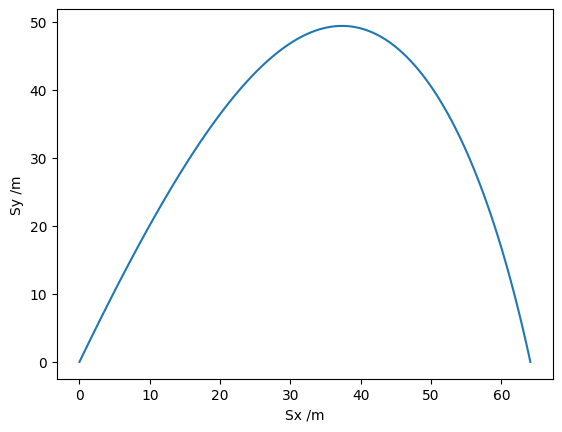

In [ ]:
# Drag coefficient, projectile radius (m), area (m2) and mass (kg).
c = 0.47
r = 0.05
A = np.pi * r**2
m = 0.2
# Air density (kg.m-3), acceleration due to gravity (m.s-2).
rho_air = 1.28
g = 9.81
# For convenience, define  this constant.
k = 0.5 * c * rho_air * A

# Initial speed and launch angle (from the horizontal).
v0 = 50
phi0 = np.radians(65)

def deriv(t, u):
    x, xdot, z, zdot = u
    speed = np.hypot(xdot, zdot)
    xdotdot = -k/m * speed * xdot
    zdotdot = -k/m * speed * zdot - g
    return xdot, xdotdot, zdot, zdotdot

# Initial conditions: x0, v0_x, z0, v0_z.
u0 = 0, v0 * np.cos(phi0), 0., v0 * np.sin(phi0)
# Integrate up to tf unless we hit the target sooner.
t0, tf = 0, 50

def hit_target(t, u):
    # We've hit the target if the z-coordinate is 0.
    return u[2]
# Stop the integration when we hit the target.
hit_target.terminal = True
# We must be moving downwards (don't stop before we begin moving upwards!)
hit_target.direction = -1

def max_height(t, u):
    # The maximum height is obtained when the z-velocity is zero.
    return u[3]

soln = solve_ivp(deriv, (t0, tf), u0, dense_output=True,
                 events=(hit_target, max_height))
#print(soln)
print('Time to target = {:.2f} s'.format(soln.t_events[0][0]))
print('Time to highest point = {:.2f} s'.format(soln.t_events[1][0]))

# A fine grid of time points from 0 until impact time.
t = np.linspace(0, soln.t_events[0][0], 100)

# Retrieve the solution for the time grid and plot the trajectory.
sol = soln.sol(t)
sx, sy = sol[0], sol[2]
print('Range to target, xmax = {:.2f} m'.format(sx[-1]))
print('Maximum height, zmax = {:.2f} m'.format(max(sy)))
plt.plot(sx, sy)
plt.xlabel('Sx /m')
plt.ylabel('Sy /m')
plt.show()

In [ ]:
mu = k/m
train_data_size = 500

**PINNs model for approximating projectile motion solution**

In [ ]:
def train_data():
  y = []
  for i in range(0,train_data_size):
      y0 = tf.Variable(6.34*np.random.rand(),trainable=True)
      y.append(y0)
  y = tf.reshape(tf.convert_to_tensor(y, dtype = tf.float32),(train_data_size,1))
  return y
y = train_data()

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=100):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()
    # Input is 1-dimensional (one spatial dimension)
    model.add(tf.keras.Input(1))
    # Append hidden layers
    for _ in range(num_hidden_layers-3):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('sigmoid'),
            kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer))
    # Output is two-dimensional
    model.add(tf.keras.layers.Dense(2))
    return model

In [ ]:
model = init_model()

In [ ]:
def gradients_x(t):
    t = tf.reshape(t, [len(t),1], name=None)
    with tf.GradientTape() as tape2:
         with tf.GradientTape() as tape1:
              tape1.watch(t)
              s = model(t)
              s_x = tf.reshape(s[:,0],[len(t),1],name=None)
         dsx_dt = tape1.gradient(s_x,t)
         tape2.watch(t)
    d2sx_dt2 = tape2.gradient(dsx_dt,t)
    return dsx_dt, d2sx_dt2
def gradients_y(t):
    t = tf.reshape(t, [len(t),1], name=None)
    with tf.GradientTape() as tape2:
         with tf.GradientTape() as tape1:
              tape1.watch(t)
              s = model(t)
              s_y = tf.reshape(s[:,1],[len(t),1],name=None)
         dsy_dt = tape1.gradient(s_y,t)
         tape2.watch(t)
    d2sy_dt2 = tape2.gradient(dsy_dt,t)
    return dsy_dt, d2sy_dt2

In [ ]:
def loss_function_ode(t_train):
    t = t_train
    dsx_dt, d2sx_dt2 = gradients_x(t)
    dsy_dt, d2sy_dt2 = gradients_y(t)
    l1 = (d2sx_dt2 + mu*np.sqrt(dsx_dt**2 + dsy_dt**2)*dsx_dt)**2
    l2 = (d2sy_dt2 + mu*np.sqrt(dsx_dt**2 + dsy_dt**2)*dsy_dt + g)**2
    l = l1 + l2
    return 10*tf.reduce_mean(l)

In [ ]:
def loss_initial_cond():
  t_0 = tf.Variable(0, trainable=True, dtype=tf.float32)
  t_0 = tf.reshape(t_0, [1,1], name=None)
  s = model(t_0)
  s_x = tf.reshape(s[0,0],[1,1],name=None)
  s_y = tf.reshape(s[0,1],[1,1],name=None)
  loss_sx0 = (s_x-0)**2
  loss_sy0 = (s_y-0)**2
  dsx_dt, d2sx_dt2 = gradients_x(t_0)
  dsy_dt, d2sy_dt2 = gradients_y(t_0)
  loss_v_0_x = (dsx_dt-v0*np.cos(phi0))**2
  loss_v_0_y = (dsy_dt-v0*np.sin(phi0))**2
  return tf.reduce_mean(loss_v_0_x) + tf.reduce_mean(loss_v_0_y) + tf.reduce_mean(loss_sx0) + tf.reduce_mean(loss_sy0)

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate = 0.01)

In [ ]:
def train_step():
  with tf.GradientTape() as tape:
       tape.watch(model.trainable_variables)
       loss = loss_function_ode(y) + loss_initial_cond()
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients([
          (grad, var)
          for (grad, var) in zip(gradients, model.trainable_variables)
          if grad is not None
        ])

In [ ]:
# Training the Model:
displaystep = 20
hist = []
for i in range(2000):
  train_step()
  if i % displaystep == 0:
     total_loss = loss_function_ode(y) + loss_initial_cond()
     hist.append(total_loss.numpy())
     y_sample = np.arange(0, 6.35, 0.005)
     proto_tensor = tf.make_tensor_proto(y_sample)
     y_ = tf.make_ndarray(proto_tensor)
     out = tf.reshape(model(y_),[len(y_),2])
     sx_ = out[:,0]
     sy_ = out[:,1]
     sx_ = tf.reshape(sx_, [len(y_)], name=None)
     sy_ = tf.reshape(sy_, [len(y_)], name=None)
     proto_tensor1= tf.make_tensor_proto(sx_)
     proto_tensor2= tf.make_tensor_proto(sy_)
     sx_ = tf.make_ndarray(proto_tensor1)
     sy_ = tf.make_ndarray(proto_tensor2)
     plt.plot(sx, sy, color='red')
     plt.plot(sx_, sy_, color='blue')
     plt.xlabel('Sx')
     plt.ylabel('Sy')
     # save the plots of numerical solutions vs neural network solutions
     '''plt.savefig("/content/drive/MyDrive/projectile_motion/plots/value{i}.png".format(i=i))'''
     plt.clf()
     print("loss: %f " % total_loss)

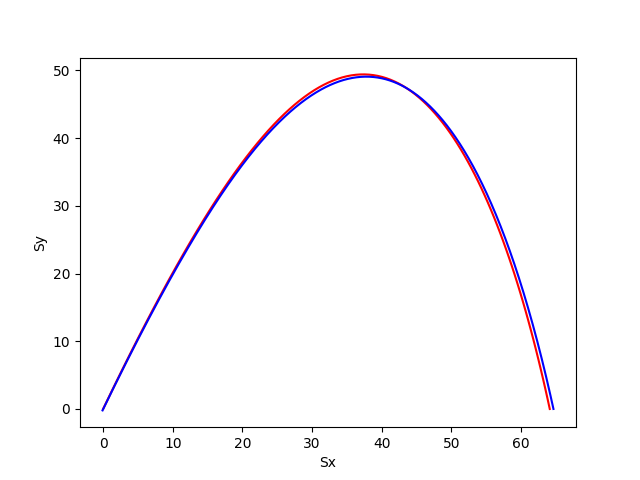

In [ ]:
# code to display the saved plots
# red plot represents neural network solution, blue plot represents numerical solution
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
'''img = plt.imread('/content/drive/MyDrive/projectile_motion/plots/fig.png')'''
imgplot = plt.imshow(img)
plt.show()'''